## 1. Multinomial GLM-HMM

In [4]:
data[30]['foraging_efficiency']

Decimal('0.7622')

/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Subdirectory 'data-aspects-dir' already exists for the file to be saved in.


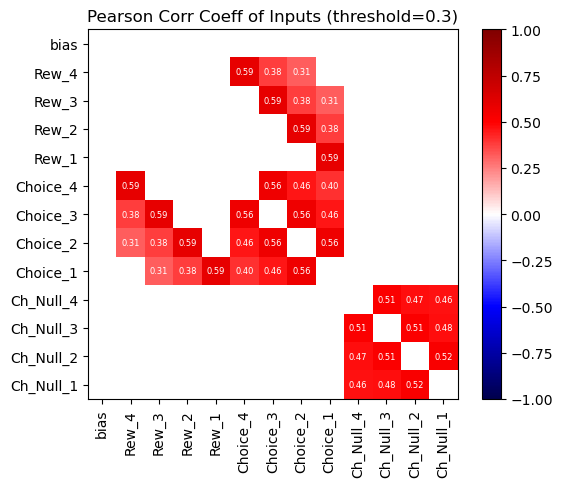

In [5]:
"""
the python environment for the code: conda activate ssm_env_python3_9 
type_save= 'data-aspects' # can be ['data-aspects' , 'HMM-latent-satas']
"""

from f_util_preprocess import *
from f_util_plot import *
from f_util_analyses import *

hparams = {
    'data_dir': get_path_to_data_dir(),
    'save_dir': get_path_to_save_dir(),
    'mouse' : 'HH10', # [FOR07, HH09, HH10]
    'experiment' : 'blockRew-coupled-baited',
    'data_type' : '.npy',
    'num_history_step' : 4,
    'num_hidden_states' : [1,2,3],
    'GLM' : 'multinomial', # can be ['bernoulli' , 'multinomial']
    'bias' : True,
    'bias_to_rich' : False,
    'water' : False,
    'obs_dim' : 1 ,          # number of observed dimensions
    'num_categories' : 3,   # number of categories for output
    'cols' : set_color_pallete(),
    'analysis_experiment_name' : 'modified_Bari', # choose from the list ['modified_Bari', 'bias_RewardOneHot_ChoiceOneHot', 'just_bias']     ['just_bias', 'bias_RewardOneHot', 'bias_ChoiceOneHot', \
    # 'bias_RewardOneHot_ChoiceOneHot', 'bias_RewardOneHot_Choice1FeatureNAN', 'bias_RewardBinary_ChoiceOneHot', 'bias_RewardWSLS_1FeatureChoiceNAN', 
    # 'bias_RewardOrdinal_Choice1Hot', 'bias_RewardWSLS_ChoiceOneHot']
    'num_iters' : 500,
    'tolerance' : 10**-5,
    'alphas' : [1, 2],
    'sigmas' : [0.5, 2], #[0.5, 0.75, 1, 2, 3, 4] #[0.5, 2] # [2, 3] 
    'output_form' : 'R0_nan1_L2',  # can be chosen from ['R0_L1_nan2', 'R0_nan1_L2']
    'observation_dim' : 1,
    'n_iters' : 500,
    'colors' : ['#ff7f00', '#4daf4a', '#377eb8', '#f781bf', '#999999', '#e41a1c', '#dede00', '#a65628', '#984ea3', '#97945a', '#c1cdc1',\
    '#00FFFF', '#FF00FF', '#FFA500', '#7FFFD4', '#00008B', '#00FF00', '#F7E7CE', '#EAC117', '#B275F7', '#9FDEBF'],
    'category_rew_prob' : [0.45,  0.4,   0.386, 0.338, 0.225, 0.113, 0.071, 0.064, 0.05 ],  
    'Sess_format': True
}


hparams['input_dim'] = n_input_dim(hparams)
hparams['alpha_sigma_sets'] = generate_hyperparameter_sets_for_mle_map(hparams['alphas'] , hparams['sigmas']) #"alpha_sigma_sets" used to be "hyperparameter_sets"

data = import_data(hparams['data_dir'] + hparams['mouse'] + hparams['data_type']) # DataFrame of size 5*n_sessions, 
# To call data of, for example, choice_history of session 2, use this form: data[2]['choice_history'], which is a numpy.ndarray of size (1 , n_trilas)

    # ''' 
    # Export all foraging sessions (for Faeze)
    #
    # The dictionary in each .npy file uses session number as the key
    # {1: {'choice_history': 1-d array, 0 = left, 1 = right, nan = ignored
    #      'reward_history': 2-d array, first dimension: left [0] / right [1], second dimension: trial number. 0 = no reward, 1 = rewarded
    #      'p_reward': underlying reward refill probabilities. Same structure as reward_history
    #      'trial_num': total trial number (including ignored trials)
    #      'foraging_efficiency': overall performance of this session
    #      },
    #  2: data for session 2,
    #  ...
    # }
    # '''
hparams['sessions'] = np.arange(1,np.shape(data)[1]+1)
hparams['tot_n_sess'] = np.shape(data)[1]
hparams['list_of_trial_count_in_chosen_sessens'] = get_list_of_trial_count_in_chosen_sessens(hparams, data)
hparams['num_input_trials_segr_by_sessions'] = get_list_of_num_trials_for_chosen_sess_in_input_array(hparams)
hparams['block_divider_trials'] = np.array(get_block_divider_in_selected_sess(hparams,data))
hparams['sess_divider_trials'] = np.array(get_sess_divider_in_selected_sess(hparams))

hparams['input_labels'] = get_input_labels(hparams)
hparams['num_trials_in_input_array'] = get_n_trials_for_input_array(hparams)
if hparams['GLM'] == 'multinomial':
    hparams['num_categories'] = 3
else:
    hparams['num_categories'] = 2



input_design_matrix_list = build_input_design_matrix(hparams, data)
output_choice_list = build_output_choice_list(hparams, data)

if np.shape(input_design_matrix_list)[2] > 1:
    plot_heatmap_of_pearson_corr_coeff_of_input_data(hparams, input_design_matrix_list, threshold = 0.3)
    plot_name = 'pearson_coeff' + '-' + hparams['mouse'] + '-' + hparams['analysis_experiment_name']
    save_plot(hparams, type_save= 'data-aspects', plot_name = plot_name)


### fold stuff to be done later ###
# num_folds = 5 # num_fold in training part
# num_folds_tt = num_folds +1
# test_fold_id = np.random.randint(0,num_folds+1, 1)
# # test_fold_id =0 ##############remive it

# print('test_fold_id : ', test_fold_id)

Until now, we have only considered the case where there are 2 output classes (the Bernoulli GLM-HMM corresponding to `C=num_categories=2`), yet the `ssm` framework is sufficiently general to allow us to fit the multinomial GLM-HMM described in Equations 1 and 2. Here we demonstrate a recovery analysis for the multinomial GLM-HMM. 

In [6]:
input_design_matrix_list[0][0]

array([ 1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  1.,  1.,  1.,  0.])

In [7]:
hparams['output_form']

'R0_nan1_L2'

In [8]:
np.shape(data)[1]

81

Text(0, 0.5, '# trial/ sess')

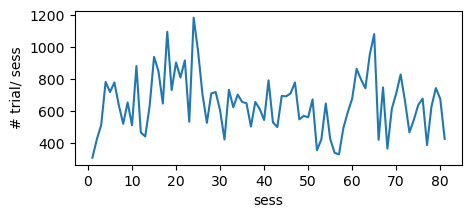

In [9]:
"""plot number of trials in session"""
fig = plt.figure(figsize=(5,2))
plt.plot(hparams['sessions'] , hparams['num_input_trials_segr_by_sessions'])
plt.xlabel('sess')
plt.ylabel('# trial/ sess')

Text(0, 0.5, 'performance')

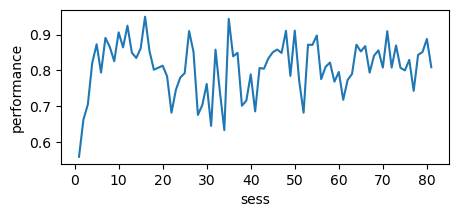

In [10]:
"""foraging efficiency"""
performance = np.zeros((len(hparams['sessions']),))
for i , sess in enumerate(hparams['sessions']):
    performance[i] = data[sess]['foraging_efficiency']

hparams['performance'] = performance
fig = plt.figure(figsize=(5,2))
plt.plot(hparams['sessions'], performance)
plt.xlabel('sess')
plt.ylabel('performance')

/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


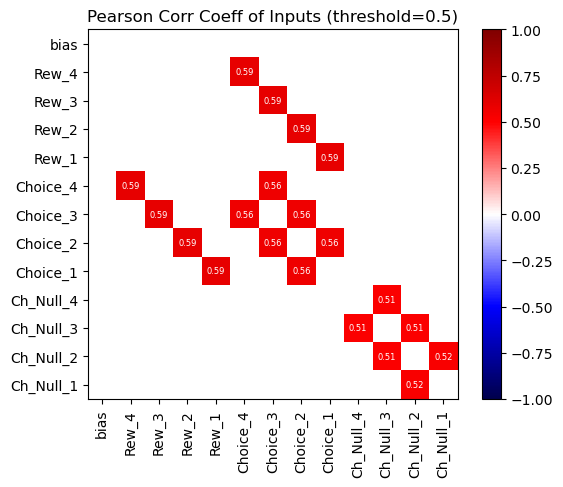

In [11]:
import ssm

"""
n_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
"""

hparams_analyses = {
    'decorrelate_input' : False,
}


# npr.seed(0)
# Set the parameters of the GLM-HMM
# num_states =  2      # number of discrete states
obs_dim = hparams['observation_dim']        # number of observed dimensions
num_categories = hparams['num_categories']    # number of categories for output
input_dim = hparams['input_dim']         # input dimensions


if hparams_analyses['decorrelate_input'] == True: 
    input_design_matrix_list = decompose_input_list(input_design_matrix_list)[0]
    # a,b,pca_ = decompose_input_list(input_design_matrix_list)
    hparams['input_labels'] = ['PC' + str(i) for i in range(1, hparams['input_dim']+1)]
    
if np.shape(input_design_matrix_list)[2] > 1:
    plot_heatmap_of_pearson_corr_coeff_of_input_data(hparams, input_design_matrix_list, threshold = 0.5)
    # im = plt.imshow(np.cov(input_design_matrix_list[0], rowvar=False), cmap="seismic")#, vmin=-1, vmax=1)
    # im = plt.imshow(np.corrcoef(input_design_matrix_list[0].T), cmap="seismic", vmin=-1, vmax=1)
    # plt.colorbar(im)

true_choices = output_choice_list
inpts = input_design_matrix_list
# a = np.array(input_design_matrix_list).squeeze().reshape(-1,17)[:,:2]
# input_design_matrix_list_1 = []
# input_design_matrix_list_1.append(a)
# inpts = input_design_matrix_list_1

# mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                    observation_kwargs=dict(C=num_categories), transitions="standard")

In [12]:
np.shape(input_design_matrix_list)

(1, 52532, 13)

In [6]:
# dataset = np.array(input_design_matrix_list).squeeze()
# transformed_data,loadings, pca_object=decompose_correlated_data_using_PCA(dataset)

# fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# for j in range(0,3):
#     axes[0].plot(pca_object.inverse_transform(weights[j,0,:]), color=hparams['colors'][j])

# for j in range(0,3):
#     axes[1].plot(pca_object.inverse_transform(weights[j,1,:]), c=hparams['colors'][j])

# # for j in range(3):
# #     axes[1].plot(c.inverse_transform(weights[j,2,:]), c=hparams['colors'][j])

# for ax in axes:
#     ax.set_xticks(range(13))
#     ax.set_xticklabels(hparams['input_labels'], rotation = 90)
#     # ax.set_ylim([-2,2])

# plt.subplots_adjust(hspace=0.3)

In the above, notice that the shape of the weights for the multinomial GLM-HMM is `(num_states, num_categories-1, input_dim)`.  Specifically, we only learn `num_categories-1` weight vectors (of size `input_dim`) for a given state, and we set the weights for the other observation class to zero. Constraining the weight vectors for one class is important if that we want to be able to identify generative weights in simulated data. If we didn't do this, it is easy to see that one could generate the same observation probabilities with a set of weight vectors that are offset by a constant vector $w_{k}$ (the index k indicates that a different offset vector could exist per state):
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{\sum_{c'=1}^C \exp\{w_{kc'}^\mathsf{T} u_t\}} = \frac{\exp\{(w_{kc}-w_{k})^\mathsf{T} u_t\}}
{\sum_{c'=1}^C \exp\{(w_{kc'}-w_{k})^\mathsf{T} u_t\}}
\end{align}
$$

Equations 1 and 2 at the top of this notebook already take into account the fact that the weights for a particular class for a given state are fixed to zero (this is why $c = C$ is handled differently).

In [7]:
num_states_2cv = range(1,8)
n_repeats=5
heldout_frac=.2
hparams['kw_cv'] = "both_data"
# kw = hparams['kw_cv'] #   """kw: choose from ["true_data", "sythetic_data, "both_data]"""

if hparams['kw_cv'] == "both_data":
    test_ll, train_ll,test_ll_base, train_ll_base = cv(hparams, num_states_2cv= num_states_2cv, n_repeats=n_repeats, heldout_frac=heldout_frac, inpts=inpts, true_choices= true_choices, kw=hparams['kw_cv'])
else:
    test_ll, train_ll = cv(hparams, num_states_2cv= num_states_2cv, n_repeats=n_repeats, heldout_frac=heldout_frac, inpts=inpts, true_choices= true_choices, kw=hparams['kw_cv'])


1


LP: -11311.5: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


true data
test_true [-0.56876914 -0.57152759 -0.56883267 -0.5711278  -0.56527725]
train_true [-0.57134884 -0.57065923 -0.57133296 -0.57075918 -0.57222181]


LP: -16044.7: 100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


synthetic data
test_synth [-0.81205139 -0.82444591 -0.81811414 -0.81877638 -0.8190819 ]
train_synth [-0.81781059 -0.81471196 -0.81629491 -0.81612935 -0.81605297]
2


LP: -11163.9: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


true data
test_true [-0.53475928 -0.52564553 -0.55501455 -0.55309808 -0.5515784 ]
train_true [-0.55774023 -0.56024782 -0.5530133  -0.55359132 -0.55413968]


LP: -16228.6: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


synthetic data
test_synth [-0.82158155 -0.82061822 -0.81347743 -0.81273061 -0.81824423]
train_synth [-0.81450948 -0.8144441  -0.81604521 -0.81652674 -0.81504091]
3


LP: -11277.1: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


true data
test_true [-0.54099613 -0.5338522  -0.54269702 -0.53548737 -0.52322999]
train_true [-0.54542931 -0.54679334 -0.54473531 -0.54613798 -0.54948434]


LP: -16440.8: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


synthetic data
test_synth [-0.81930437 -0.80123197 -0.80858254 -0.81118648 -0.81295314]
train_synth [-0.81410692 -0.8180788  -0.8163542  -0.81587479 -0.81549301]
4


LP: -11264.9: 100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


true data
test_true [-0.54432014 -0.54374924 -0.53290383 -0.5344014  -0.55318867]
train_true [-0.5456276  -0.53953926 -0.54235336 -0.54175147 -0.53837368]


LP: -16575.4: 100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


synthetic data
test_synth [-0.81504463 -0.81512056 -0.81434589 -0.79952712 -0.82184069]
train_synth [-0.81316953 -0.81408126 -0.81417822 -0.81754257 -0.81194337]
5


LP: -11503.3: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


true data
test_true [-0.54544992 -0.55718063 -0.5163533  -0.5338466  -0.53102174]
train_true [-0.53519487 -0.5348241  -0.54372276 -0.53920809 -0.5401713 ]


LP: -16848.5: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


synthetic data
test_synth [-0.81221954 -0.8079533  -0.80415659 -0.81580121 -0.8055079 ]
train_synth [-0.81377201 -0.81481307 -0.81678477 -0.81315205 -0.81552967]
6


LP: -11644.1: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


true data
test_true [-0.53873764 -0.52530738 -0.53347682 -0.52987246 -0.53535207]
train_true [-0.5373931  -0.53772111 -0.53885989 -0.53826377 -0.53694123]


LP: -16955.3: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


synthetic data
test_synth [-0.8227025  -0.81628085 -0.81259287 -0.82330484 -0.8221084 ]
train_synth [-0.8098194  -0.81165426 -0.81259137 -0.81049241 -0.81054497]
7


LP: -11781.0: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


true data
test_true [-0.53837341 -0.54417521 -0.52779807 -0.52747785 -0.54090036]
train_true [-0.53499125 -0.5334481  -0.5360897  -0.5367866  -0.53350858]


LP: -17171.8: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]

synthetic data
test_synth [-0.82012106 -0.79841461 -0.83315838 -0.81655746 -0.81661021]
train_synth [-0.8109079  -0.81543767 -0.80756707 -0.8113476  -0.81121661]


In [8]:
"""save test_ll, train_ll,test_ll_base, train_ll_base"""
from f_util_plot import *
save_file(hparams, 'data-aspects', file_name= 'test_ll', file_to_save = test_ll)
save_file(hparams, 'data-aspects', file_name= 'train_ll', file_to_save = train_ll)
save_file(hparams, 'data-aspects', file_name= 'test_ll_base', file_to_save = test_ll_base)
save_file(hparams, 'data-aspects', file_name= 'train_ll_base', file_to_save = train_ll_base)

Subdirectory 'data-aspects-dir' already exists for the file to be saved in.
Subdirectory 'data-aspects-dir' already exists for the file to be saved in.
Subdirectory 'data-aspects-dir' already exists for the file to be saved in.
Subdirectory 'data-aspects-dir' already exists for the file to be saved in.


In [ ]:
# import pickle
# with open("test_ll.pickle", "wb") as file1:
#     pickle.dump(test_ll, file1)

# with open("train_ll.pickle", "wb") as file1:
#     pickle.dump(train_ll, file1)

# with open("test_ll_base.pickle", "wb") as file1:
#     pickle.dump(test_ll_base, file1)

# with open("train_ll_base.pickle", "wb") as file1:
#     pickle.dump(train_ll_base, file1)

In [7]:
test_ll

[array([-0.5896638 , -0.60501827, -0.59381276, -0.61389442, -0.60343121]),
 array([-0.59721717, -0.57349972, -0.57668839, -0.57254598, -0.57341163]),
 array([-0.57694973, -0.58306799, -0.5658606 , -0.57840419, -0.5719241 ]),
 array([-0.55181594, -0.56693743, -0.563833  , -0.56510294, -0.57879991]),
 array([-0.56143015, -0.57302698, -0.57429394, -0.56676891, -0.55961048]),
 array([-0.56721135, -0.56008   , -0.57458281, -0.57846794, -0.58041455]),
 array([-0.5618713 , -0.55599635, -0.58244238, -0.55674236, -0.55856203])]

In [10]:
plot_LL_for_model_selection(test_ll, train_ll, test_ll_base, train_ll_base, num_states_2cv= num_states_2cv, kw = hparams['kw_cv'])

NameError: name 'test_ll' is not defined

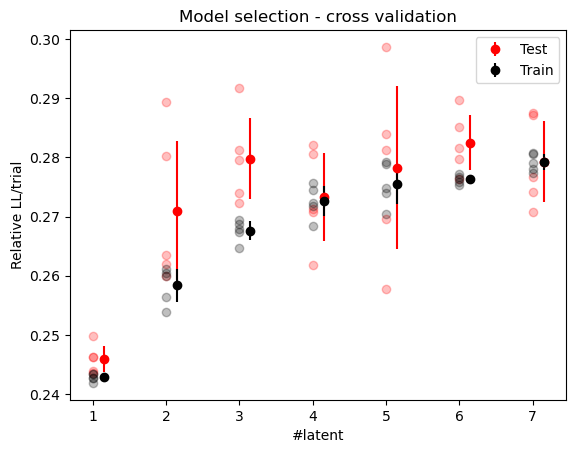

In [10]:
num_states_2cv = range(1,8)
n_repeats=2
heldout_frac=.1
hparams['kw_cv'] = "both_data"
plot_Relative_LL_for_model_selection(test_ll, train_ll, test_ll_base, train_ll_base, num_states_2cv= num_states_2cv, kw = hparams['kw_cv'])

In [8]:
np.exp(.37)**600

2.5904486187164714e+96

In [ ]:
"""Get LL and CV on baseline model, where inputs comes from the mouse, and outputs are generated using a Nernouli model using the same % of R/L/Null actions.
baseline model assumes that animals flip a 3-sided coin on each trial so as to decide to go right, and the probability of going right is equal to the fraction 
of trials in the training set in which the animal chose to go to the right. Baseline model is the log-likelihood of the same test set under a Categorical distribution
 model of animal choice behavior.
"""
# num_states_2cv = range(1,5)
# n_repeats=3
# heldout_frac=.1

test_ll_base, train_ll_base = cv(hparams, num_states_2cv= num_states_2cv, n_repeats=n_repeats, heldout_frac=heldout_frac, inpts=inpts, true_choices= true_choices_simul)

print('test', test_ll)
print('train',train_ll)

In [ ]:
# def generate_synthetic_choice(hparams, true_choices):
#     # choice encoding : 0 = right, 1 = left, 2 = nan (ignored)
#     p_base = np.zeros((3,))
#     true_choice_base =[]
#     for i in range(hparams['num_categories']):
#         p_base[i] = np.sum(np.array(true_choices).squeeze()==i) / hparams['num_trials_in_input_array']

#     categories = [0, 1, 2]

#     # Sample from the categorical distribution
#     choice_base = np.random.choice(categories, size = hparams['num_trials_in_input_array'], p=p_base)
#     true_choice_base.append(choice_base.reshape(-1,1))

#     return true_choice_base


In [74]:
# # ll of baseline model for training set

# # choice encoding : 0 = right, 1 = left, 2 = nan (ignored)
# p_base = np.zeros((3,))
# true_choice_base =[]
# for i in range(num_categories):
#     p_base[i] = np.sum(np.array(true_choices).squeeze()==i) / hparams['num_trials_in_input_array']

# categories = [0, 1, 2]

# # Sample from the categorical distribution
# choice_base = np.random.choice(categories, size = hparams['num_trials_in_input_array'], p=p_base)
# true_choice_base.append(choice_base.reshape(-1,1))

In [ ]:
#     # ll of baseline model for training set
#     random_choice_train = np.random.randint(2, size=np.shape(true_choices_train))
#     baseline_ll_arbitrary_states_train.append(arbitrary_states_glmhmm.log_likelihood(list(random_choice_train), inputs=true_input_train) )

# num_train_trial = (num_sess - num_test_sessions) * num_trials_per_sess
# ll_bit_per_trial_train = (np.array(train_ll_arbitrary_states) - np.array(baseline_ll_arbitrary_states_train)) / (np.log(2) * num_train_trial)

#     # ll of baseline model for training set
#     right_proportion = np.sum(np.array(choices_train)==0) / np.array(choices_train).size
#     num_repetition = 100
#     # random_choices_train = choices_train
#     baseline_ll_train = np.zeros((num_repetition,1))
#     for i in range(num_repetition):
#         # random_choice_train = np.random.randint(2, size=np.shape(choices_train))     # np.shape(choices_train) = (num_sess_train , num_trial_per_sess, 1) like (10, 100, 1)
#         # np.random.shuffle(random_choices_train)  # np.shape(choices_train) = (num_sess_train , num_trial_per_sess, 1) like (10, 100, 1)
#         random_choices_train = np.random.binomial(1, right_proportion, np.shape(choices_train))
#         baseline_ll_train[i] = glm_hmm_mle_map.log_likelihood(list(random_choices_train), inputs=input_train)
#     baseline_ll_train = np.mean(baseline_ll_train)

In [7]:
def ll_per_trial(ll, ll_baseline, num_trial):
    
    ll_bit_per_trial = (np.array(ll) - np.array(ll_baseline)) / (np.log(2) * num_trial)

    return ll_bit_per_trial

In [ ]:
gg

In [83]:
# # check log_likelihood of fit GLM-HMM for different initialization 
# num_states =  4      # number of discrete states

# for i in range(4):
#     mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                    observation_kwargs=dict(C=num_categories), transitions="standard")
    
#     fit_ll = mle_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=hparams['n_iters'], tolerance=hparams['tolerance'])
#     mle_final_ll = mle_glmhmm.log_likelihood(true_choices, inputs=inpts) #/ hparams['num_trials_in_input_array']
#     print(mle_final_ll)


Converged to LP: -23515.8:   9%|▉         | 46/500 [00:13<02:12,  3.43it/s]


-22905.287362956533


Converged to LP: -23666.0:  12%|█▏        | 61/500 [00:16<01:59,  3.68it/s]


-23055.47951282109


Converged to LP: -23665.6:  14%|█▍        | 69/500 [00:22<02:22,  3.02it/s]


-23055.094070412164


Converged to LP: -23683.8:  37%|███▋      | 186/500 [01:05<01:50,  2.84it/s]

-23073.350138446178


In [ ]:
-13187.413 - 3

In [5]:
num_states =  3   # number of discrete states

mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories), transitions="standard")

fit_ll = mle_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=hparams['n_iters'], tolerance=hparams['tolerance'])
mle_final_ll = mle_glmhmm.log_likelihood(true_choices, inputs=inpts) #/ hparams['num_trials_in_input_array']
print(mle_final_ll)

Converged to LP: -32343.3:  12%|█▏        | 62/500 [00:26<03:08,  2.32it/s]

-31732.840700004737


In [13]:
np.shape(true_choices)

(1, 52532, 1)

In [177]:
"""save mpdel"""
# import pickle

# # Create an instance of the class with specific parameters
# instance = mle_glmhmm

# # Save the instance to a file using pickle
# filename = 'instance.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(instance, file)

# print("Instance saved to", filename)

'save mpdel'

In [178]:
"""retreave model"""
# # Load the instance from the file
# filename = 'instance.pkl'
# with open(filename, 'rb') as file:
#     loaded_instance = pickle.load(file)

# print("Loaded instance parameters:")


'retreave model'

In [6]:
weights = mle_glmhmm.observations.params
log_transitions = mle_glmhmm.transitions.params

[2 2 2 0 2 2 2 2 0 0 0 0 2 0 0 2 1 2 1 1 2 2 2 1 2 2 2 2 1 2 1 1 1 2 1 0 1
 2 1 2 2 2 0 1 1 1 0 2 1 1 1 1 2 2 0 0 2 1 2 2 1 1 0 2 2 0 0 0 1 1 1 1 1 0
 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 2 1 0 0 0 1 1 1 1 1]


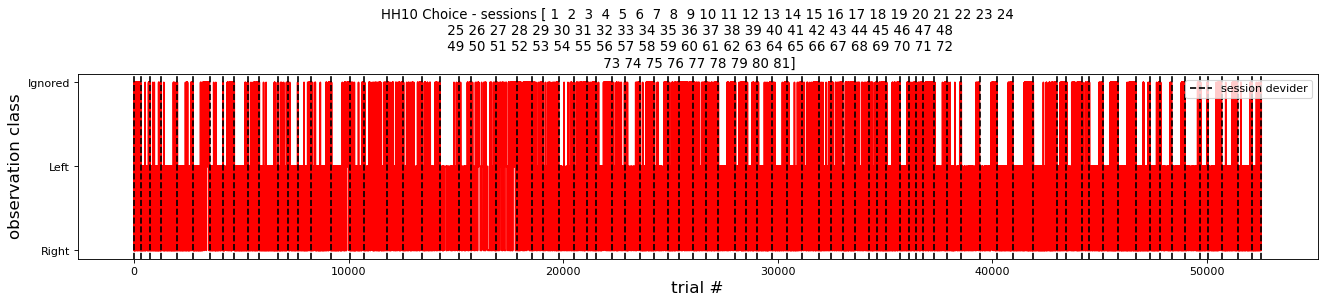

In [7]:
from f_util_plot import *
plot_choice_vs_trials(hparams, true_choices)

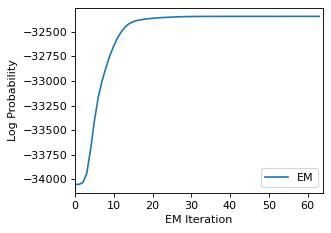

In [8]:
plot_log_prob_of_model_vs_EM_iteration_output_of_fit_fun_training_progress(fit_ll)

In [9]:
hparams

{'data_dir': '/Users/faezeamin/Documents/Allen/ssm_forkedFromLinderman_Cloned/ForkedFromSL/data/',
 'save_dir': '/Users/faezeamin/Documents/Allen/ssm_forkedFromLinderman_Cloned/ForkedFromSL/results/',
 'mouse': 'HH10',
 'experiment': 'blockRew-coupled-baited',
 'data_type': '.npy',
 'num_history_step': 4,
 'num_hidden_states': [1, 2, 3],
 'GLM': 'multinomial',
 'bias': True,
 'bias_to_rich': False,
 'water': False,
 'obs_dim': 1,
 'num_categories': 3,
 'cols': ['#1f77b4',
  '#ff7f0e',
  '#2ca02c',
  '#d62728',
  '#9467bd',
  '#8c564b',
  '#e377c2',
  '#7f7f7f',
  '#bcbd22',
  '#17becf'],
 'analysis_experiment_name': 'modified_Bari',
 'num_iters': 500,
 'tolerance': 1e-05,
 'alphas': [1, 2],
 'sigmas': [0.5, 2],
 'output_form': 'R0_nan1_L2',
 'observation_dim': 1,
 'n_iters': 500,
 'colors': ['#ff7f00',
  '#4daf4a',
  '#377eb8',
  '#f781bf',
  '#999999',
  '#e41a1c',
  '#dede00',
  '#a65628',
  '#984ea3',
  '#97945a',
  '#c1cdc1',
  '#00FFFF',
  '#FF00FF',
  '#FFA500',
  '#7FFFD4',
  '#

In [183]:
hparams['colors']= ['#ff7f00',
 '#4daf4a',
 '#377eb8',
 '#f781bf',
 '#999999',
 '#e41a1c',
 '#dede00',
 '#a65628',
 '#984ea3',
 '#97945a',
 '#c1cdc1',
 '#00FFFF',
 '#FF00FF',
 '#FFA500',
 '#7FFFD4',
 '#00008B',
 '#00FF00',
 '#F7E7CE',
 '#EAC117',
 '#B275F7',
 '#9FDEBF']

In [184]:
# hparams['colors'] = ['#377eb8','#ff7f00',  '#4daf4a' ]

In [185]:
hparams['input_labels'] = get_input_labels(hparams)

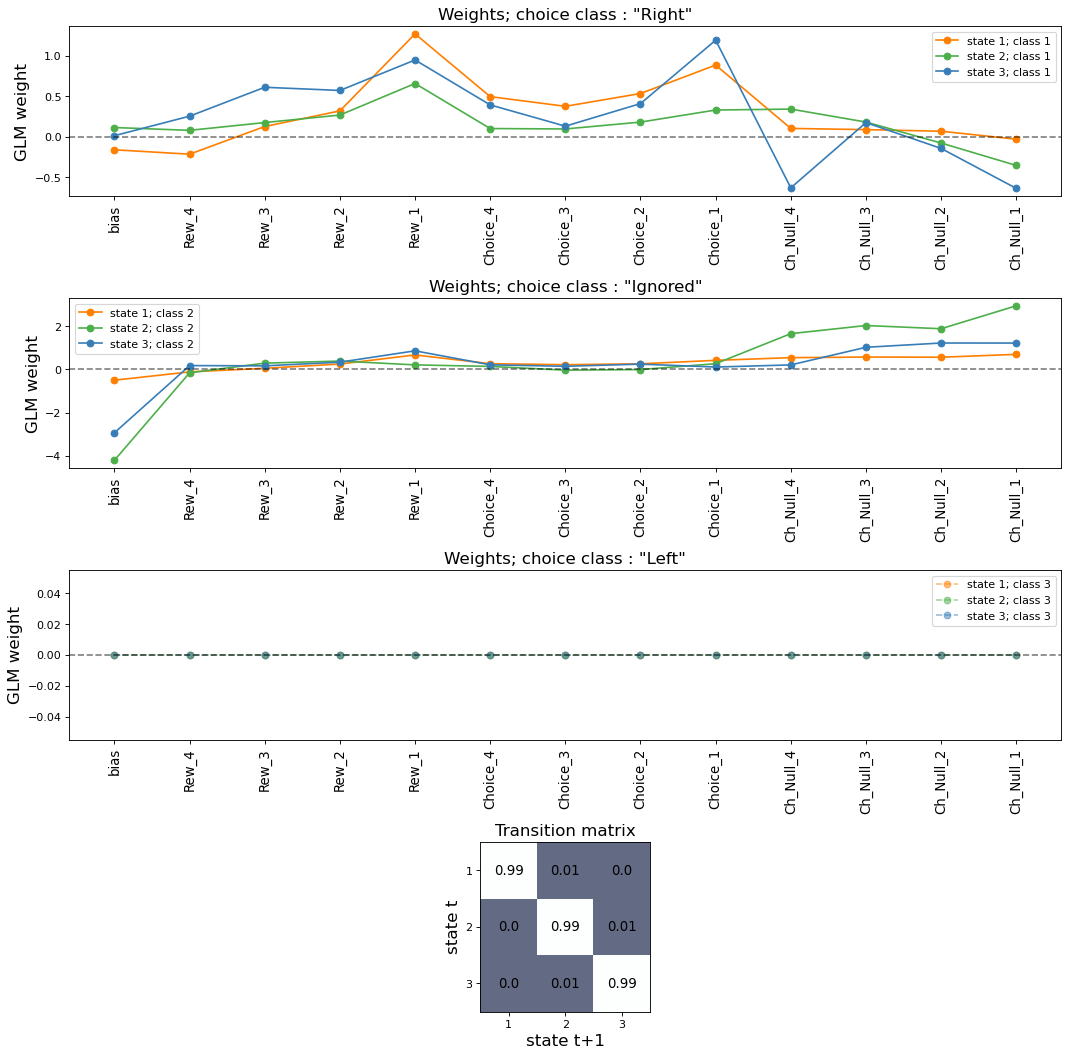

In [10]:
plot_weights_per_class_and_transition_matrix(hparams, weights, log_transitions, num_states)

In [11]:
# Get expected states:
posterior_probs = [mle_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices, inpts)]

In [12]:
data[2]['p_reward'].shape

(2, 426)

In [13]:
hparams['block_divider_trials']

array([    0,     5,    13,    18,    21,    25,    26,    27,    28,
          29,    30,    31,    32,    33,    34,    35,    36,    37,
          38,    58,    98,   115,   134,   198,   216,   261,   282,
         308,   315,   353,   406,   438,   476,   503,   565,   595,
         649,   678,   718,   720,   730,   763,   815,   838,   869,
         902,   966,  1030,  1065,  1201,  1243,  1319,  1375,  1428,
        1469,  1536,  1596,  1624,  1725,  1815,  1973,  2026,  2025,
        2073,  2177,  2239,  2329,  2391,  2489,  2589,  2744,  2796,
        2882,  2937,  3003,  3055,  3150,  3240,  3340,  3514,  3523,
        3578,  3683,  3762,  3852,  3931,  3997,  4069,  4125,  4160,
        4230,  4334,  4395,  4453,  4509,  4578,  4629,  4680,  4727,
        4782,  4867,  4967,  5051,  5120,  5182,  5282,  5316,  5334,
        5401,  5457,  5557,  5611,  5680,  5771,  5800,  5845,  5941,
        6019,  6109,  6209,  6290,  6367,  6435,  6497,  6574,  6635,
        6686,  6727,

In [14]:
def compare_arrays(arr):
    a = np.zeros((arr.shape[1]), dtype=int)
    for i in range(len(arr[0])):
        if arr[0][i] < arr[1][i]: # p(left) < p(right)
            a[i] = int(1)
        if arr[0][i] > arr[1][i]: # p(left) > p(right)
            a[i] = -1

    return a

# Example usage
array = np.array([[5, 6, 7, 8, 9, 10, 11, 12, 13, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9, 20]])
result = compare_arrays(array)
print(result) 

[-1 -1 -1 -1 -1 -1 -1 -1 -1  1]


In [15]:
hparams['block_divider_trials'][-1]

52532

In [16]:
hparams['block_divider_trials'][:5]

array([ 0,  5, 13, 18, 21])

In [17]:
list_blocks = []
for sess_id,sess in enumerate(hparams['sessions']):

    a = compare_arrays(data[sess]['p_reward'])
    list_blocks.extend(a[hparams['num_history_step']:])

    
    # cumulative_trila_num = np.array(np.where(np.diff(data[sess]['p_reward'][0]) != 0)[0])
    # cumulative_trila_num = np.append(cumulative_trila_num, hparams['num_input_trials_segr_by_sessions'][sess_id])
    # cumulative_trila_num[0] = cumulative_trila_num[0]-hparams['num_history_step']
    # hparams['num_input_trials_segr_by_sessions'][sess_id]
    # list_blocks.append(cumulative_trila_num)

In [18]:
data[1]['p_reward'][:,:22]

array([[1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 0., 0., 0.]])

In [19]:
list_blocks[:20]

[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1]

In [20]:
np.shape(list_blocks)

(52532,)

In [21]:
# hparams['colors'] = ['#377eb8', '#4daf4a', '#ff7f00']

In [22]:
# def get_block_divider_in_selected_sess_rowwise(hparams,data): to del
#     """This function outputs a list of size (n_sess). for each sess, we have an array of block_dividers_in_the_sess. 
#     output: list_blocks - list :    size (n_sess)
#                                     each element of list: size (1, n_blocks_in_corresponding_sess)
#     """
#     list_blocks = []
#     for sess_id,sess in enumerate(hparams['sessions']):
#         cumulative_trila_num = np.array(np.where(np.diff(data[sess]['p_reward'][0]) != 0)[0])
#         cumulative_trila_num = np.append(cumulative_trila_num, hparams['num_input_trials_segr_by_sessions'][sess_id])
#         cumulative_trila_num[0] = cumulative_trila_num[0]-hparams['num_history_step']
#         hparams['num_input_trials_segr_by_sessions'][sess_id]
#         list_blocks.append(cumulative_trila_num)

#     return list_blocks

Text(0, 0.5, 'p(state)')

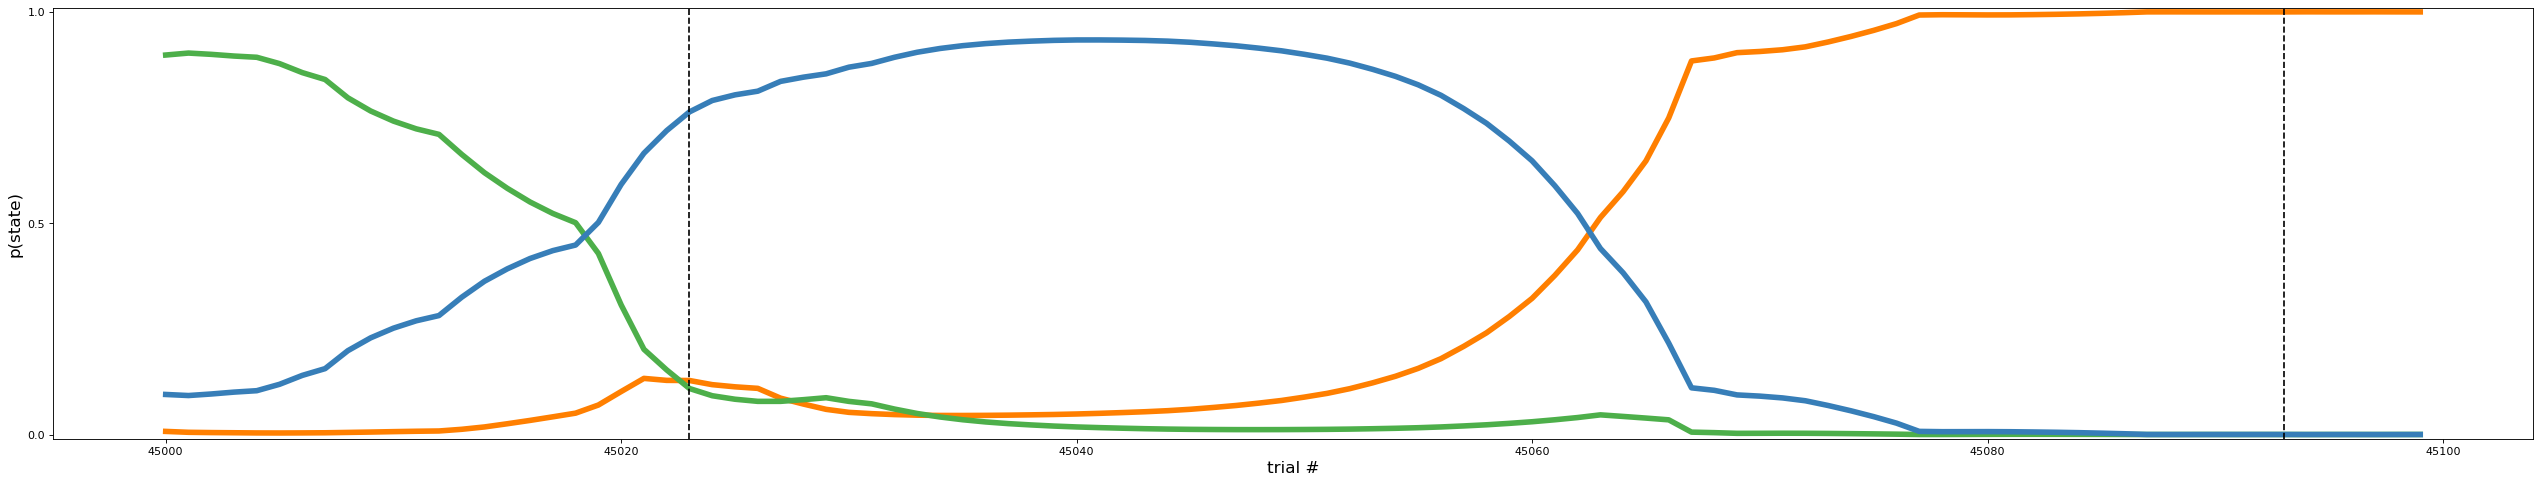

In [23]:
fig = plt.figure(figsize=(40, 7), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; later in rowwise can be choosen any index between 0 and num_sess-1
start = 20000
stop = -1
start = 20000
stop = 23000
start = 45000
stop = 45100
if stop == -1: 
    stop = hparams['num_trials_in_input_array']
for k in range(num_states):
    plt.plot(range(start,stop), posterior_probs[sess_id][start:stop, k], label="State " + str(k + 1), lw=5,
             color=hparams['colors'][k])
    

# block_divider_trials = np.array(get_block_divider_in_selected_sess(hparams,data))
# plt.axvline(x=0, color='black', linestyle='--', label='session devider')
idx = np.arange(np.searchsorted(hparams['block_divider_trials'], start),  np.searchsorted(hparams['block_divider_trials'], stop))
# idx = np.where((np.array(block_divider_trials) >= start) & (np.array(block_divider_trials) <=stop))[0]
if len(idx) >0:
    for num_trials in hparams['block_divider_trials'][idx]:
        plt.axvline(x=num_trials, color='black', linestyle='--')

# sess_devider_trials = np.cumsum(np.array(hparams['num_input_trials_segr_by_sessions']))
# sess_divider_trials = np.array(get_sess_divider_in_selected_sess(hparams))
idx = np.where((hparams['sess_divider_trials'] >= start) & (hparams['sess_divider_trials'] <=stop))[0]
if len(idx) >0:
    for num_trials in hparams['sess_divider_trials'][idx]:
        plt.axvline(x=num_trials, color='black', linestyle='--', lw=5)

    
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)



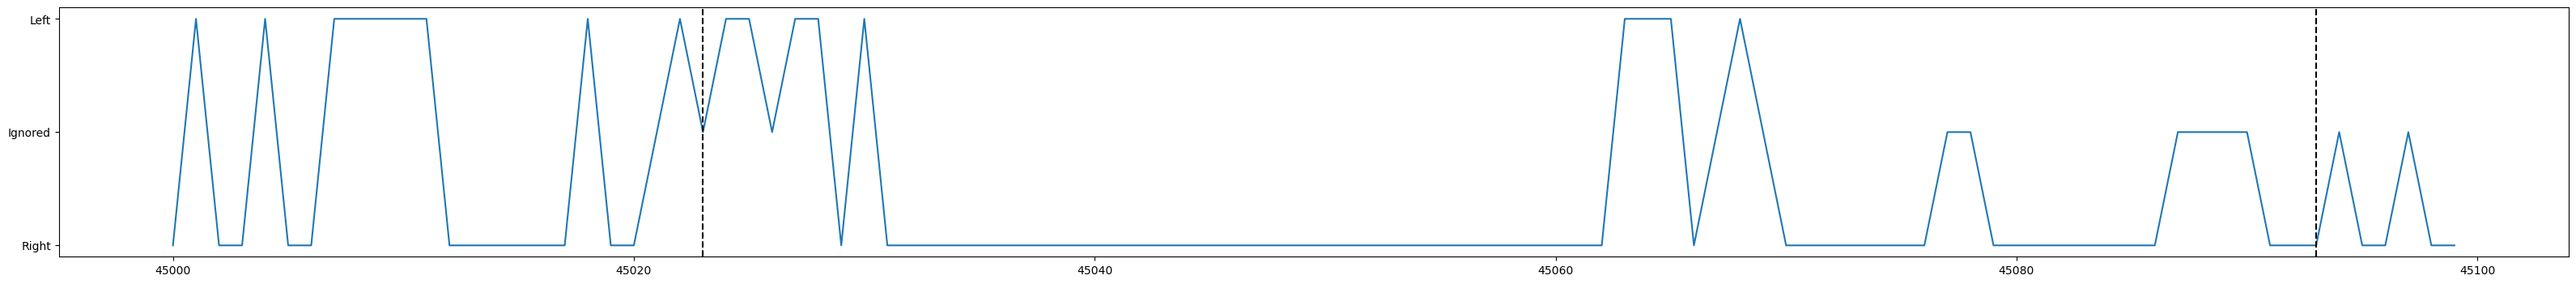

In [24]:
fig = plt.figure(figsize=(40,4))
plt.plot(range(start,stop), true_choices[0][start:stop])
plt.yticks([0, 1, 2], ['Right' , 'Ignored', 'Left'])

# block_devider_trials = np.array(get_block_divider_in_selected_sess(hparams,data))
# plt.axvline(x=0, color='black', linestyle='--', label='session devider')
idx = np.where((np.array(hparams['block_divider_trials']) >= start) & (np.array(hparams['block_divider_trials']) <=stop))[0]
if len(idx) >0:
    for num_trials in hparams['block_divider_trials'][idx]:
        plt.axvline(x=num_trials, color='black', linestyle='--')

# sess_devider_trials = np.cumsum(np.array(hparams['num_input_trials_segr_by_sessions']))
# sess_divider_trials = np.array(get_sess_divider_in_selected_sess(hparams))
idx = np.where((hparams['sess_divider_trials'] >= start) & (hparams['sess_divider_trials'] <=stop))[0]
if len(idx) >0:
    for num_trials in hparams['sess_divider_trials'][idx]:
        plt.axvline(x=num_trials, color='black', linestyle='--', lw=5)

In [25]:
get_sess_of_trial(hparams, 22000)

32

46682 47343


Text(0.5, 1.0, 'session 72')

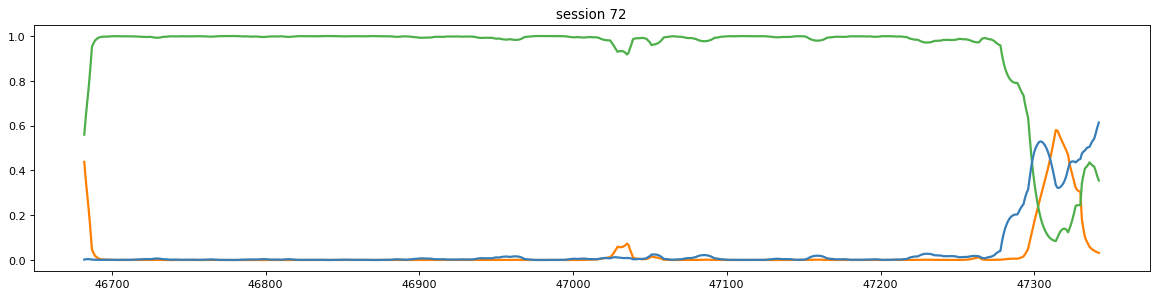

In [26]:
sess_ =  72# 32, 36, 30,   o 25     b 13, 14, 37, 38, 39     g 29     all 15 4o     25
 
if sess_ ==1:
    start_trial = 0 
else:
    start_trial = hparams['sess_divider_trials'][sess_ -2]
    end_trial = hparams['sess_divider_trials'][sess_ -1]
print(start_trial, end_trial)


fig = plt.figure(figsize=(18, 4), dpi=80, facecolor='w', edgecolor='k')

for k in range(num_states):
    plt.plot(range(start_trial,end_trial), posterior_probs[sess_id][start_trial:end_trial, k], label="State " + str(k + 1), lw=2,
             color=hparams['colors'][k])
plt.title('session {}'.format(sess_))


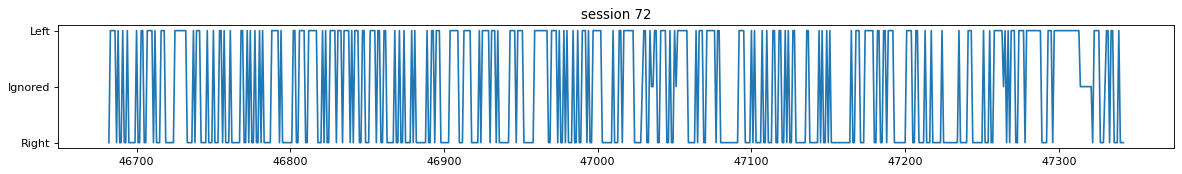

In [27]:
fig = plt.figure(figsize=(18, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(start_trial, end_trial), true_choices[0][start_trial: end_trial])
plt.yticks([0, 1, 2], ['Right' , 'Ignored', 'Left'])
plt.title('session {}'.format(sess_))
plt.show()

In [28]:
# data[33]['p_reward']

In [29]:
"""save and reload hparams as json file"""
# import json

# # Save the dictionary as JSON
# with open('data.json', 'w') as file:
#     json.dump(hparams, file)

# # Reload the JSON file into a dictionary
# with open('data.json', 'r') as file:
#     loaded_hparams = json.load(file)

# # Print the reloaded dictionary
# print(loaded_hparams)

"""print the hparam"""
for key, value in hparams.items():
    # print(key + ":", value)
    print(key)

data_dir
save_dir
mouse
experiment
data_type
num_history_step
num_hidden_states
GLM
bias
bias_to_rich
water
obs_dim
num_categories
cols
analysis_experiment_name
num_iters
tolerance
alphas
sigmas
output_form
observation_dim
n_iters
colors
category_rew_prob
Sess_format
input_dim
alpha_sigma_sets
sessions
tot_n_sess
list_of_trial_count_in_chosen_sessens
num_input_trials_segr_by_sessions
block_divider_trials
sess_divider_trials
input_labels
num_trials_in_input_array
performance


Text(0, 0.5, 'frac. occupancy')

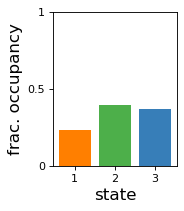

In [61]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)


fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = hparams['colors'][z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

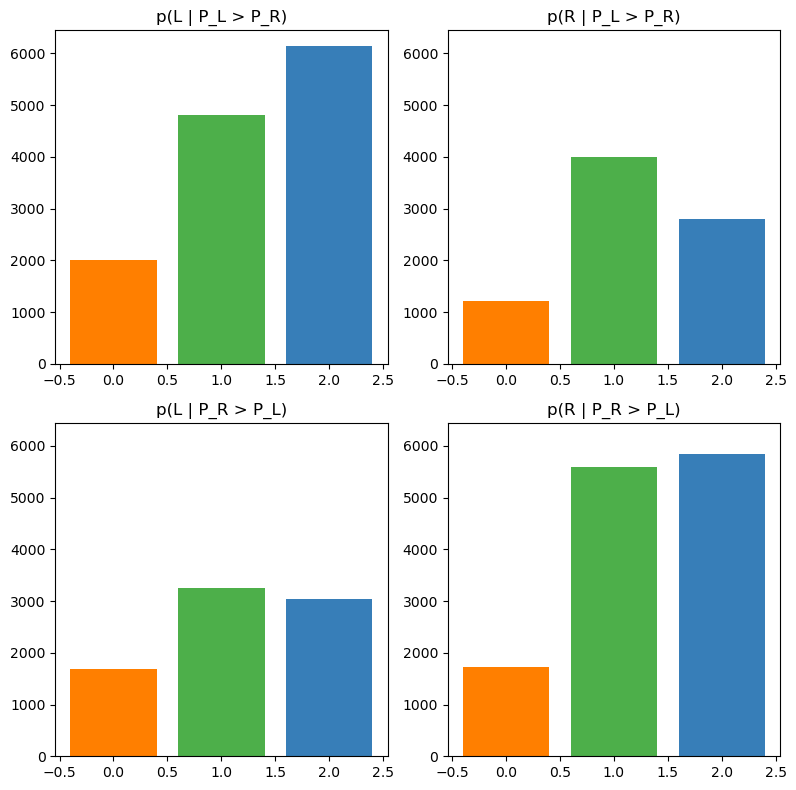

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# if hparams['output_form'] == 'R0_nan1_L2':
cond_leftRich = np.array(list_blocks) == -1
cond_rightRich = np.array(list_blocks) == 1
num_states


# axs[0, 0].bar(range(1), np.sum(true_choices[0][cond_leftRich, 0]==2))
# axs[0, 0].set_title('p(L | P_L > P_R)')

# axs[0, 1].bar(range(1), np.sum(true_choices[0][cond_leftRich, 0]==0))
# axs[0, 1].set_title('p(R | P_L > P_R)')

# axs[1, 0].bar(range(1),  np.sum(true_choices[0][cond_rightRich, 0]==2))
# axs[1, 0].set_title('p(L | P_R > P_L)')

# axs[1, 1].bar(range(1), np.sum(true_choices[0][cond_rightRich, 0]==0))
# axs[1, 1].set_title('p(R | P_R > P_L)')

# # assert np.sum(true_choices[0][cond_leftRich, 0]==2) + np.sum(true_choices[0][cond_leftRich, 0]==0) == np.sum(true_choices[0][cond_rightRich, 0]==2) + np.sum(true_choices[0][cond_rightRich, 0]==0)

# max_ylim = np.max([axs[0, 0].get_ylim()[1], axs[0, 1].get_ylim()[1], axs[1, 0].get_ylim()[1], axs[1, 1].get_ylim()[1]])
# axs[0, 0].set_ylim(0, max_ylim)
# axs[0, 1].set_ylim(0, max_ylim)
# axs[1, 0].set_ylim(0, max_ylim)
# axs[1, 1].set_ylim(0, max_ylim)


choiceLeft_LeftRich = []
for state in range(num_states):
    choiceLeft_LeftRich.append(np.sum(true_choices[0][(cond_leftRich) & (state_max_posterior == state),0] == 2))
axs[0, 0].bar(range(3), choiceLeft_LeftRich, color = hparams['colors'])
axs[0, 0].set_title('p(L | P_L > P_R)')


choiceRight_LeftRich = []
for state in range(num_states):
    choiceRight_LeftRich.append(np.sum(true_choices[0][(cond_leftRich) & (state_max_posterior == state),0] == 0))
axs[0, 1].bar(range(3), choiceRight_LeftRich, color = hparams['colors'])
axs[0, 1].set_title('p(R | P_L > P_R)')


choiceLeft_RightRich = []
for state in range(num_states):
    choiceLeft_RightRich.append(np.sum(true_choices[0][(cond_rightRich) & (state_max_posterior == state),0] == 2))
axs[1, 0].bar(range(3),  choiceLeft_RightRich, color = hparams['colors'])
axs[1, 0].set_title('p(L | P_R > P_L)')


choiceRight_RightRich = []
for state in range(num_states):
    choiceRight_RightRich.append(np.sum(true_choices[0][(cond_rightRich) & (state_max_posterior == state),0] == 0))
axs[1, 1].bar(range(3), choiceRight_RightRich, color = hparams['colors'])
axs[1, 1].set_title('p(R | P_R > P_L)')


max_ylim = np.max([axs[0, 0].get_ylim()[1], axs[0, 1].get_ylim()[1], axs[1, 0].get_ylim()[1], axs[1, 1].get_ylim()[1]])
axs[0, 0].set_ylim(0, max_ylim)
axs[0, 1].set_ylim(0, max_ylim)
axs[1, 0].set_ylim(0, max_ylim)
axs[1, 1].set_ylim(0, max_ylim)


plt.tight_layout()

plt.show()


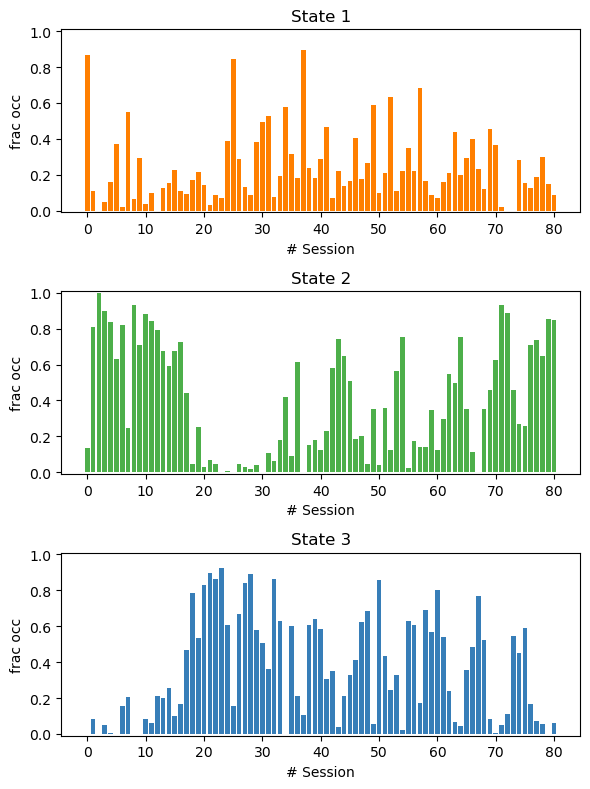

In [62]:
frac_occupancies_per_sess = get_frac_occ_across_sess(hparams, state_max_posterior)
plot_evolution_of_frac_occ(hparams, frac_occupancies_per_sess)

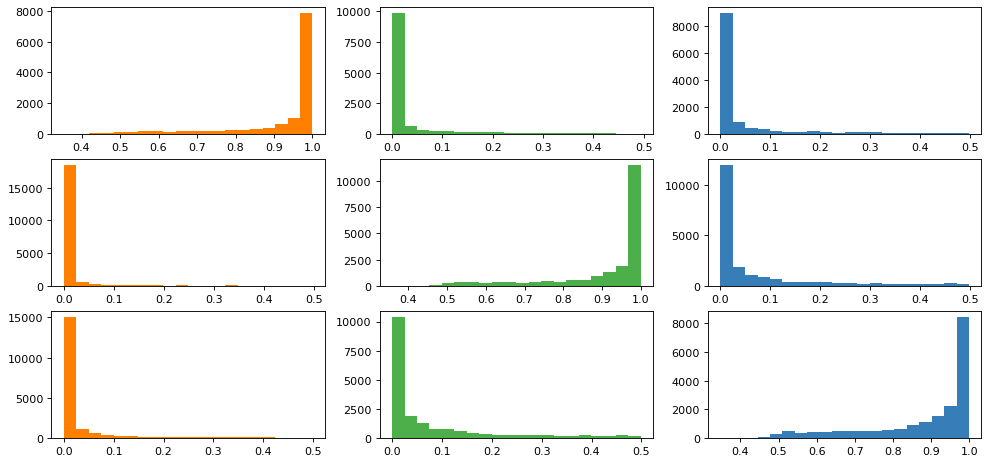

In [63]:
fig = plt.figure(figsize=(15, 7), dpi=80)

posterior_probs_concat_sess_train = np.reshape(np.array(posterior_probs) , (1,-1,num_states)).squeeze()   # (30000, 3)
for i in range(num_states):

    for j in range(num_states):
        plt.subplot(num_states,num_states,i*num_states+j+1)
        plt.hist(posterior_probs_concat_sess_train[state_max_posterior == i, j], bins = 20, color =hparams['colors'][j]) # density =True,

In [ ]:
"""PCA on inputs and input-output data"""
inpts_4pca = np.array(inpts).reshape(-1,input_dim) # good to plot
# true_choices_4pca = np.array(true_choices).reshape(-1,1) # not to plot separately
# input_output_4pca = np.concatenate((inpts_4pca, true_choices_4pca), axis=1) # good to plot
# # choices_inpts_4pca = build_input_choice_array_for_n_history_steps_all_sess_modifiedBari_encoding(hparams,data) # good to plot
# inpt_reward_part_4pca =  build_input_reward_array_for_n_history_steps_all_sess_Right1LeftMinus1Otherwise0_encoding(hparams,data) # good to plot

# # do_pca(input_output_4pca)

"""t-SNE on inputs and output data"""
# do_t_SNE(inpts_4pca, true_choices_4pca, n_components=2)
do_t_SNE(inpts_4pca, state_max_posterior, n_components=2)


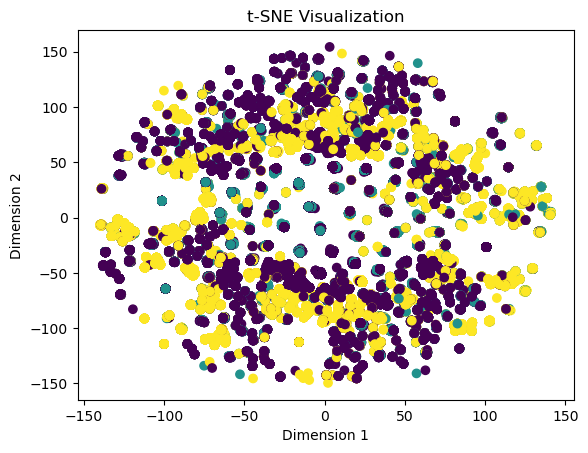

In [ ]:
"""PCA on inputs and input-output data"""
inpts_4pca = np.array(inpts).reshape(-1,input_dim) # good to plot
true_choices_4pca = np.array(true_choices).reshape(-1,1) # not to plot separately
input_output_4pca = np.concatenate((inpts_4pca, true_choices_4pca), axis=1) # good to plot
# # choices_inpts_4pca = build_input_choice_array_for_n_history_steps_all_sess_modifiedBari_encoding(hparams,data) # good to plot
# inpt_reward_part_4pca =  build_input_reward_array_for_n_history_steps_all_sess_Right1LeftMinus1Otherwise0_encoding(hparams,data) # good to plot

# # do_pca(input_output_4pca)

"""t-SNE on inputs and output data"""
# do_t_SNE(inpts_4pca, true_choices_4pca, n_components=2)
do_t_SNE(input_output_4pca, state_max_posterior, n_components=2)

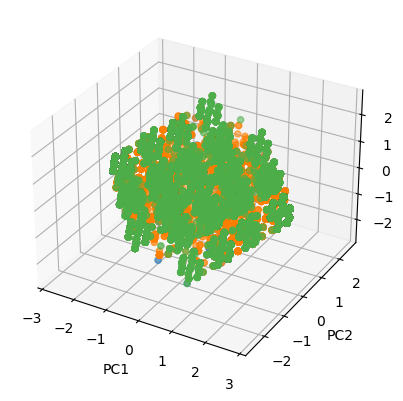

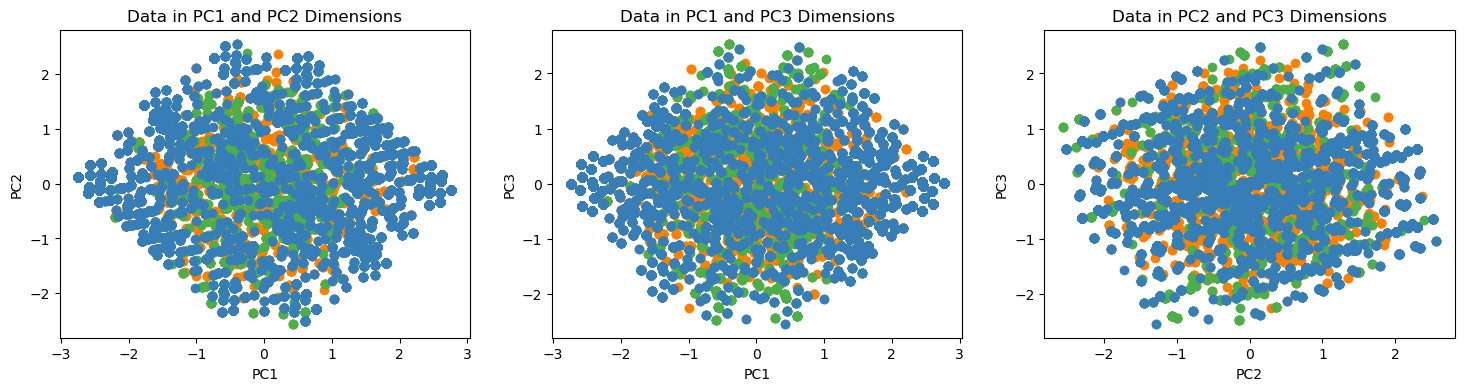

PC1 Variance Explained: 47.26%
PC2 Variance Explained: 12.67%
PC3 Variance Explained: 9.05%
PC4 Variance Explained: 7.78%
PC5 Variance Explained: 6.80%


In [76]:
"""PCA on inputs and input-output data"""
inpts_4pca = np.array(inpts).reshape(-1,input_dim) # good to plot
true_choices_4pca = np.array(true_choices).reshape(-1,1) # not to plot separately
input_output_4pca = np.concatenate((inpts_4pca, true_choices_4pca), axis=1) # good to plot
inpt_choices_part_4pca = build_input_choice_array_for_n_history_steps_all_sess_modifiedBari_encoding(hparams,data) # good to plot
inpt_reward_part_4pca =  build_input_reward_array_for_n_history_steps_all_sess_Right1LeftMinus1Otherwise0_encoding(hparams,data) # good to plot

# do_pca(input_output_4pca, colors = hparams['colors'][::-1], clustering = true_choices_4pca)
# do_pca(inpts_4pca, colors = hparams['colors'][::-1], clustering = true_choices_4pca)
# do_pca(inpt_choices_part_4pca, colors = hparams['colors'][::-1], clustering = true_choices_4pca)
# do_pca(inpt_reward_part_4pca, colors = hparams['colors'][::-1], clustering = true_choices_4pca)



do_pca(input_output_4pca, colors = hparams['colors'], clustering = state_max_posterior)
# do_pca(inpts_4pca, colors = hparams['colors'], clustering = state_max_posterior)
# do_pca(inpt_choices_part_4pca, colors = hparams['colors'], clustering = state_max_posterior)
# do_pca(inpt_reward_part_4pca, colors = hparams['colors'], clustering = state_max_posterior)


In [ ]:
np.shape(inpts_4pca)

(52532, 13)

In [ ]:
np.shape(true_choices_4pca)

(52532, 1)

In [ ]:
np.shape(state_max_posterior)

(52532,)

In [ ]:
np.sum(true_choices_4pca==2)

23298

In [ ]:
state_max_posterior.shape

(52532,)

In [ ]:
np.unique(state_max_posterior)

array([0])

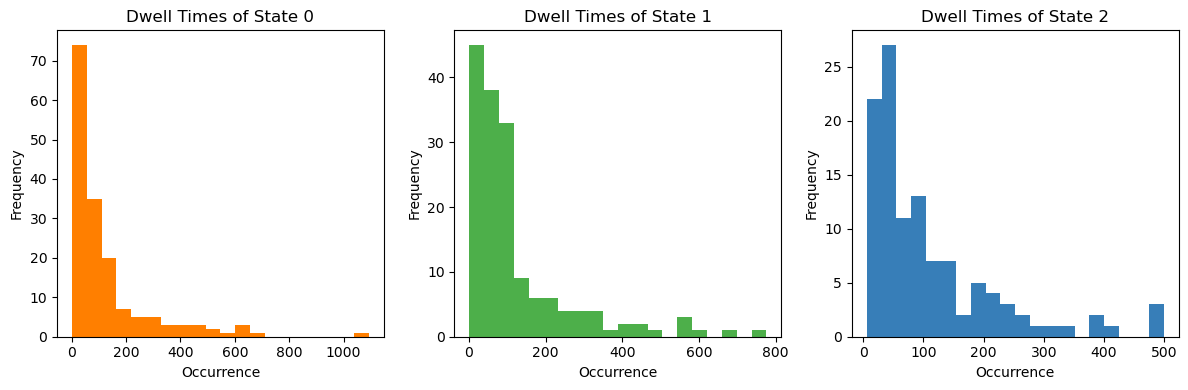

In [ ]:
"""dwell times of states across all of the data (both training and validation sets). [to be modified for sesseion-based analysis]"""

# calculate the length of dwellind in each states
idx_switch_state_ = np.array(np.where(np.diff(state_max_posterior)!=0))[0]+1
idx_switch_state_ = np.append(idx_switch_state_, len(state_max_posterior))
idx_switch_state = idx_switch_state_[0]
idx_switch_state = np.append(idx_switch_state, np.diff(idx_switch_state_))
# idx_switch_state = np.concatenate((idx_switch_state_[0], np.diff(idx_switch_state_ )))

#find the corresponding states
states_order = state_max_posterior[idx_switch_state_-1]

#plot 
unique_states = np.unique(states_order)

# coloroos = ['#377eb8', '#4daf4a','#ff7f00']
# state_labelooo = [2,1,0]

fig, axs = plt.subplots(1, frac_occupancies_per_sess.shape[0], figsize=(12, 4))  # Create a subplot grid

for i, state_label in enumerate(unique_states):
    state_occurrences = idx_switch_state[states_order == state_label]
    # state_occurrences = idx_switch_state[states_order == state_labelooo[i]]
    
    # plt.hist(state_occurrences, bins=20, color = hparams['colors'][i])
    # # plt.hist(state_occurrences, bins=20, color = coloroos[i])
    # plt.xlabel('Occurrence')
    # plt.ylabel('Frequency')
    # plt.title('Dwell Times of State {}'.format(state_label))
    # # plt.title('Dwell Times of State {}'.format(state_labelooo[i]))
    # plt.show()


    axs[i].hist(state_occurrences, bins=20, color = hparams['colors'][i])   
    # axs[i].scatter(performance, state_i, color = coloroos[i])
    axs[i].set_xlabel('Occurrence')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title('Dwell Times of State {}'.format(state_label))

plt.tight_layout()
plt.show()

t-value: 3.7397312043285327
p-value: 0.0004187251263105818
Correlation coefficient for State 1 and performance: 0.44, and the p-value is 4.19e-04
t-value: -5.310234134782119
p-value: 1.7421807072537376e-06
Correlation coefficient for State 2 and performance: -0.57, and the p-value is 1.74e-06
t-value: 1.6420956919206613
p-value: 0.10589029733715716
Correlation coefficient for State 3 and performance: 0.21, and the p-value is 1.06e-01


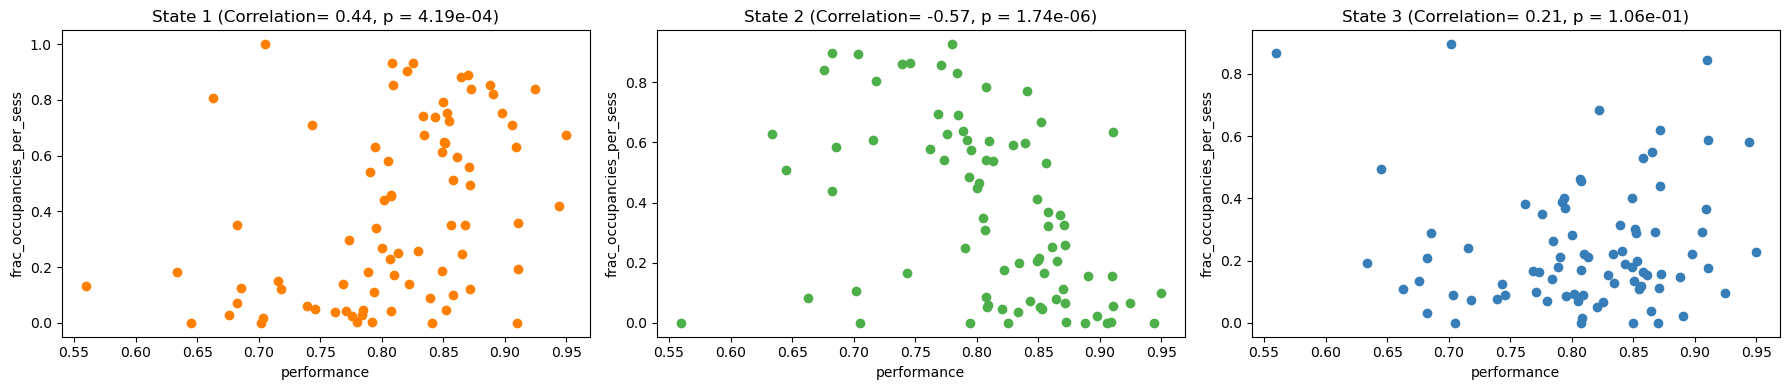

In [ ]:
from scipy.stats import t

starting_trial = 20
correlations = np.corrcoef(performance[starting_trial:], frac_occupancies_per_sess[:,starting_trial:])  # Calculate correlation coefficients
degrees_of_freedom = len(performance[starting_trial:]) - 2

fig, axs = plt.subplots(1, frac_occupancies_per_sess.shape[0], figsize=(18, 4))  # Create a subplot grid

# coloroos = ['#377eb8', '#4daf4a','#ff7f00']

for i in range(frac_occupancies_per_sess.shape[0]):
    correlation = correlations[0, i+1]  # Extract correlation coefficient
    state_i = frac_occupancies_per_sess[i]  # Extract a state of frac_occupancies_per_sess

    # perform a hypothesis test to determine if the correlation is statistically significant, usig the t-test and calculate the p-value.
    t_value = correlation * np.sqrt(degrees_of_freedom / (1 - correlation ** 2))
    p_value = 2 * (1 - t.cdf(abs(t_value), df=degrees_of_freedom))

    print("t-value:", t_value)
    print("p-value:", p_value)

    axs[i].scatter(performance, state_i, color = hparams['colors'][i])   
    # axs[i].scatter(performance, state_i, color = coloroos[i])
    axs[i].set_xlabel('performance')
    axs[i].set_ylabel('frac_occupancies_per_sess')
    axs[i].set_title('State {} (Correlation= {:.2f}, p = {:.2e})'.format(i+1, correlation, p_value))

    print('Correlation coefficient for State {} and performance: {:.2f}, and the p-value is {:.2e}'.format(i+1, correlation,  p_value))

plt.tight_layout()
plt.show()

t-value: -0.024104808486164142
p-value: 0.984657373417368
Correlation coefficient for State 1 and num_trials_per_sess: -0.0241, and the p-value is 9.85e-01
t-value: 0.11962509228031704
p-value: 0.924204480283999
Correlation coefficient for State 2 and num_trials_per_sess: 0.1188, and the p-value is 9.24e-01
t-value: -0.1363336892001052
p-value: 0.9137390945627151
Correlation coefficient for State 3 and num_trials_per_sess: -0.1351, and the p-value is 9.14e-01


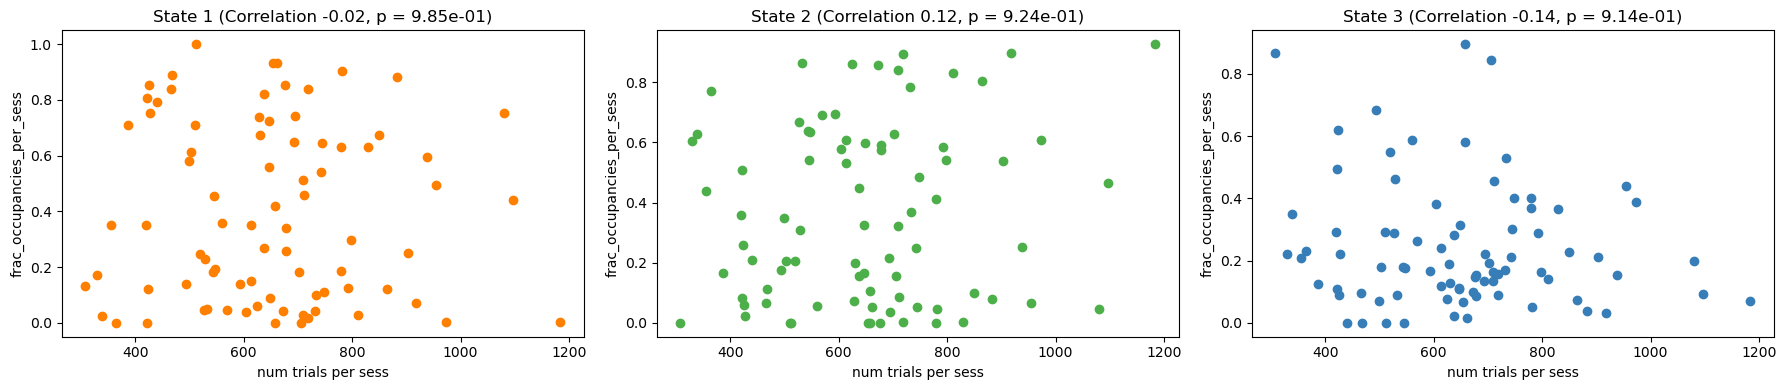

In [ ]:
correlations = np.corrcoef(hparams['num_input_trials_segr_by_sessions'], frac_occupancies_per_sess)  # Calculate correlation coefficients  [:,35:]
degrees_of_freedom = len(frac_occupancies_per_sess) - 2

fig, axs = plt.subplots(1, frac_occupancies_per_sess.shape[0], figsize=(18, 4))  # Create a subplot grid

for i in range(frac_occupancies_per_sess.shape[0]):
    correlation = correlations[0, i+1]  # Extract correlation coefficient
    state_i = frac_occupancies_per_sess[i]  # Extract a state of frac_occupancies_per_sess

    # perform a hypothesis test to determine if the correlation is statistically significant, usig the t-test and calculate the p-value.
    t_value = correlation * np.sqrt(degrees_of_freedom / (1 - correlation ** 2))
    p_value = 2 * (1 - t.cdf(abs(t_value), df=degrees_of_freedom))

    print("t-value:", t_value)
    print("p-value:", p_value)
    
    axs[i].scatter(hparams['num_input_trials_segr_by_sessions'], state_i, color = hparams['colors'][i])
    axs[i].set_xlabel('num trials per sess')
    axs[i].set_ylabel('frac_occupancies_per_sess')
    axs[i].set_title('State {} (Correlation {:.2f}, p = {:.2e})'.format(i+1, correlation, p_value))

    print('Correlation coefficient for State {} and num_trials_per_sess: {:.4f}, and the p-value is {:.2e}'.format(i+1, correlation, p_value))

plt.tight_layout()
plt.show()


/var/folders/r9/b7xk0p4523sg5rc0lhnngn_40000gn/T/ipykernel_3102/13154180.py:7: RuntimeWarning: invalid value encountered in power
  y = 1 - (1 - p) ** x


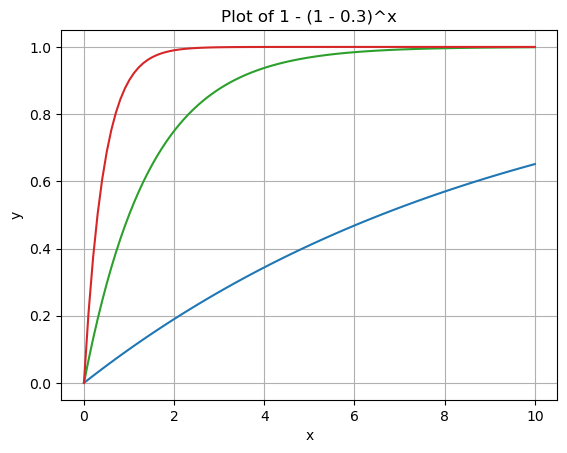

In [ ]:
# Generate x values
x = np.linspace(0, 10, 100)

# Calculate y values using the given function

for p in [.1,2,.5, .9]:
    y = 1 - (1 - p) ** x

    # Create the plot
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot of 1 - (1 - 0.3)^x')
    plt.grid(True)
# plt.show()
# plt.legend()

In [ ]:
def test():
    

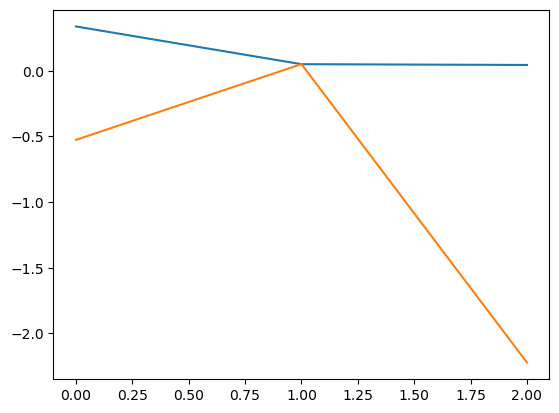

In [15]:
import numpy as np
import matplotlib.pyplot as plt
X = np.random.normal(0, 1, size=(3, 2))
A = np.eye(2,2) * 1.01
Y = A @ X.T
plt.plot(X)


In [16]:
X

array([[ 0.33736863, -0.52570228],
       [ 0.05033191,  0.05081588],
       [ 0.04435827, -2.22074251]])